# Figure 6: leakage comparison
In this Notebook, we shall create a plot showing control performed through a Spike Coding Network (SCN). The plot shows two Spring-Mass-Damper (SMD) systems, of which one is controlled through an SCN estimator and controller, and the other through an idealized LQG controller. Thi notebook serves as a comparison between different leakage constant settings, contributing to decreased spikig. Additionally, the size of the bounding box (the bounding box factor) is decreased, such that spiking is very sparse in general. The work in this notebook is carried out for "Closed-form control with spike coding networks" by F.S. Slijkhuis, S.W. Keemink and P. Lanillos (https://doi.org/10.48550/arXiv.2212.12887).

## Imports
Nothing too special here, we shall use Numpy for matrices and Matplotlib for plotting. The Python-files initialization.py and simulation.py contain helper functions which will prevent clutter in this notebook. Please refer to the files themselves to learn more about the functions within them.

In [275]:
import numpy as np #Numpy for matrix calculations
import matplotlib.pyplot as plt #Matplotlib for plotting
import initialization, simulation #Helper functions for initialization and simulation are located in these two Python files. Please see the files themselves for more details.

## Initialization
For initialization, we shall define parameters relevant to the simulations in this notebook. As mentioned earlier, we are simulating two SMD systems: one controlled using an SCN controller and the other through an idealized LQG. Both the controllers and SMD systems will be simulated using Forward Euler. But first, we must define the relevant parameters.

In [276]:
#Forward Euler parameters
time = 10 #Total simulation time in seconds
dt = 0.0001 #Length of a single timestep

#Spring-Mass-Damper System(s) parameters
m = 20 #Mass (in kg)
k = 6 #Spring constant (in N/m)
c = 2 #Constant of proportionality (dampening, in Ns/m = kg/s)
x0 = np.array([0, 0]) #Initial state of the SMD system.

#Other system parameters
C = np.array([[1,0],
              [0,0]]) #Initialization of the C matrix (because y=Cx+noise)
Vn_cov = 0.001 #Sensor noise covariance (y=Cx+noise)
Vd_cov = 0.001 #Disturbance noise covariance (noise on the SMD)

#SCN Controller parameters
network_size = 50 #The number of neurons in the SCN
signal_dimensions = 4 #The dimensions of the signal, which is 4 here because the target state is also encoded into the network
lam_list = [0,1,10] #The leakage constant of the network, lambda
Vv_sigma = 0.000001 #Voltage noise sigma; noise on the voltage
bounding_box_factor=1 #Bounding box factor, a factor by which the SCN controller weights are divided to increase/decrease the size of the bounding box

#Control parameters
Q = np.array([[10,0],
              [0,1]]) #The Q-matrix, cost of deviations from the state
R = 0.001 #Cost of actuation

Next, we shall run some of the code from initialization.py, required to initialize some of the parameters and matrices used in the simulation loop.

In [277]:
#Forward Euler simulation
times,Nt = initialization.FE_init(time,dt) #times is a list of timesteps which we will loop over, Nt is the total number of timesteps (length of times)

#SMD System A and B matrices
A,B = initialization.SMD_init(m,k,c) #A and B are the system matrix and input matrix in state-space representation (according to Ax+Bu)

#Initialization of the Kalman filter gain matrix to be used inside of the SCN estimator and idealized Kalman filter
Kf = initialization.Kalman_init(A,C,Vn_cov,Vd_cov) #From the A and C matrices and noise covariances, we can calculate the Kalman filter gain matrix

#Initialization of the LQR gain matrix to be used inside of the SCN controller and idealized LQG
Kc = initialization.Control_init(A,B,Q,R)

#Initialization of the state-matrices, containing the states of the simulated SMD systems over time
X = initialization.X_init(x0,Nt) #Requires x0 as the first state of the simulated SMD system, and Nt for the matrix dimensions
X_2 = initialization.X_init(x0,Nt) #We run two SMD systems with different controllers, so we need two state matrices

#Target state parameters
x0_des = np.full([Nt+1],0) #Desired x0, position.
x1_des = np.full([Nt+1],0) #Desired x1, velocity.

#Change desired state over time
x0_des[int(Nt/3):] = 10

x_des = np.array([x0_des,x1_des]) #Desired states over time.

#Error matrices, will be updated during the simulation
error_ideal=np.zeros([len(x0),Nt+1]) #Error between idealzied LQG and SMD system
error_scn=np.zeros([len(x0),Nt+1]) #Error between SCN controller and SMD system

#Initialization of other matrices used in simulation, U, Y, X_hat (state matrix of SCN estimator), X_hat_fe (state matrix of idealized Kalman filter), uDIST and uNOISE (noise matrices)
U,Y,U_2,Y_2,X_hat,X_hat_fe,uDIST,uNOISE,Dx,error_scn,error_ideal = initialization.ControlLoop_init(X,X_2,error_scn,error_ideal,x_des,dt,A,B,C,x0,Nt,Vd_cov,Vn_cov)

Rank of controllability-matrix: 2


## Simulation
Now that we have defined all of the parameters we need, we can define how to run the simulation. For individual SMD and SCN steps, we shall make use of simulation.py.

In [278]:
def run_simulation(Nt,X,X_2,A,B,U,U_2,uDIST,dt,Y,Y_2,C,uNOISE,r,s,V,D,T,lam,O_f,O_s,O_c,F_c,O_k,F_k,Vv_sigma,X_hat,X_hat_fe,Kf,Kc,x_des,error_scn,error_ideal,signal_dimensions):
    
    #Looping over the entire range of Nt, we have all the timesteps in our simulation
    for t in range(Nt):
        #First, simulate one step of both simulated SMD system
        X[:,t+1] = simulation.run_DSlinearized_step(X[:,t],A,B,U[:,t],uDIST[:,t],dt)
        X_2[:,t+1] = simulation.run_DSlinearized_step(X_2[:,t],A,B,U_2[:,t],uDIST[:,t],dt)
        
        #Update the error matrices
        error_scn[:,t+1] = np.abs(X[:,t+1]-x_des[:,t+1])
        error_ideal[:,t+1] = np.abs(X_2[:,t+1]-x_des[:,t+1])

        #Our controllers only have access to Y, which is the partially observable state plus noise
        Y[:,t+1] = C@X[:,t+1] + uNOISE[:,t+1]
        Y_2[:,t+1] = C@X_2[:,t+1] + uNOISE[:,t+1]

        #Simulate a single step of the SCN controller
        r[:,t+1],s[:,t+1],V[:,t+1],U[:,t+1] = simulation.run_SCNcontrol_step(Y[:,t],x_des[:,t],Dx[:,t],r[:,t],s[:,t],V[:,t],D,T,lam,Kc,O_f,O_s,O_c,F_c,O_k,F_k,B,C,t,dt,Vv_sigma)
        
        #Run a step of the idealized controller which we compare the SCN to
        X_hat_fe[:,t+1] = simulation.run_Kfidealized_step(X_hat_fe[:,t],A,B,U_2[:,t],Kf,Y_2[:,t],C,dt)

        #U_2 is the control signal of the idealized controller
        U_2[:,t+1] = -Kc@(X_hat_fe[:,t+1]-x_des[:,t])
    
    return X,X_2,error_scn,error_ideal,s

Next, we run a single simulation for plotting.

In [279]:
def run_with_lam(lam,Nt,X,X_2,A,B,U,U_2,uDIST,dt,Y,Y_2,C,uNOISE,s,Vv_sigma,X_hat,X_hat_fe,Kf,Kc,x_des,error_scn,error_ideal,signal_dimensions):
    #Initializaton of the SCN controller, given parameters, we calculate D, T, V, s, r and all of the connectivity
    D,T,V,s,r,O_f,O_s,O_c,F_c,O_k,F_k = initialization.ControllerSCN_init(signal_dimensions,Nt,A,B,C,Kf,Kc,network_size,lam,bounding_box_factor=bounding_box_factor)

    X_SCN,X_ideal,error_scn,error_ideal,s = run_simulation(Nt,X,X_2,A,B,U,U_2,uDIST,dt,Y,Y_2,C,uNOISE,r,s,V,D,T,lam,O_f,O_s,O_c,F_c,O_k,F_k,Vv_sigma,X_hat,X_hat_fe,Kf,Kc,x_des,error_scn,error_ideal,signal_dimensions)
    
    return X_SCN,X_ideal,error_scn,error_ideal,s

Next, we run the simulation for all specified leakage constants:

In [280]:
X_SCN_list = []
X_ideal_list = []
s_list = []
#Running simulation for multiple lambdas
for lam in lam_list:
    X_SCN,X_ideal,_,_,s = run_with_lam(lam,Nt,X,X_2,A,B,U,U_2,uDIST,dt,Y,Y_2,C,uNOISE,s,Vv_sigma,X_hat,X_hat_fe,Kf,Kc,x_des,error_scn,error_ideal,signal_dimensions)
    X_SCN_list.append(X_SCN)
    X_ideal_list.append(X_ideal)
    s_list.append(s)

## Plotting
Now that we have obtained our filled state matrices, we can plot everything.

In [309]:
def plot_lam(i,show_legend=True):
    char = chr(ord('`')+i+1)
    fig = plt.figure()
    fig, axs = plt.subplots(3,1, sharex=True, squeeze=True, gridspec_kw = {'hspace':0.1,'height_ratios':[0.5,0.5,1]})
    fig.set_figheight(4)
    fig.set_figwidth(8)
    legend_fontsize=12

    legend=[]
    axs[0].plot(np.arange(0,time+dt,dt),X_ideal_list[i][0],color='#E3000B',linewidth=3)
    legend.append("Idealized LQR")
    axs[0].plot(np.arange(0,time+dt,dt),X_SCN_list[i][0],color='#00B050')
    legend.append("SCN Controller")
    axs[0].plot(np.arange(0,time+dt,dt),x_des[0],linestyle='dashed',c="#0070C0")
    legend.append("Target")

    legend=[]
    axs[1].plot(np.arange(0,time+dt,dt),X_ideal_list[i][1],color='#E3000B',linewidth=3)
    legend.append("Idealized LQR")
    axs[1].plot(np.arange(0,time+dt,dt),X_SCN_list[i][1],color='#00B050')
    legend.append("SCN Controller")
    axs[1].plot(np.arange(0,time+dt,dt),x_des[1],linestyle='dashed',c="#0070C0")
    legend.append("Target")
    if show_legend:
        axs[1].legend(legend,fontsize=legend_fontsize,loc='upper left',bbox_to_anchor=(0,2))
        
    axs[0].set_ylabel('$x$ $(m)$',fontsize = 12)
    axs[1].set_ylabel('$v$ $(m/s)$',fontsize = 12)

    axs[0].set_ylim([-2,15])
    axs[1].set_ylim([-6,12])

    #We use a scatterplot for the spike trains:
    axs[2].scatter(np.nonzero(s_list[i])[1]/10000,np.nonzero(s_list[i])[0],marker=".",s=0.1,color='black')
    axs[2].set_xlabel('time ($s$)',fontsize = 12)
    axs[2].set_ylabel('neuron nr.',fontsize = 12)

    plt.savefig('./img/fig6'+char+'.png', facecolor='white', transparent=False, dpi=300, bbox_inches='tight')
    plt.show()

We can count the number of total spikes in the simulation.

In [310]:
def print_sparsity_info(i):
    print("The total number of spikes in the simulation: %d" % np.unique(s_list[i], return_counts=True)[1][1])
    print("The average number of spikes per second: %d" % (np.unique(s_list[i], return_counts=True)[1][1] / time))

    print("The total number of spikes in control period: %d" % np.unique(s_list[i][:,int(Nt/3):], return_counts=True)[1][1])
    print("The average number of spikes per second in control period: %d" % (np.unique(s_list[i][:,int(Nt/3):], return_counts=True)[1][1] / time/3*2))

Now, for each lambda value:

<Figure size 432x288 with 0 Axes>

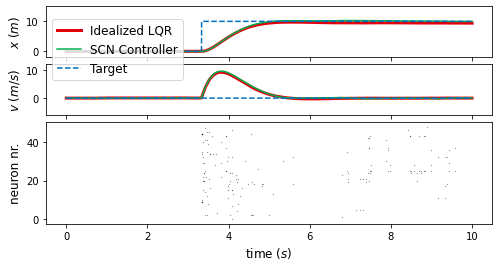

The total number of spikes in the simulation: 163
The average number of spikes per second: 16
The total number of spikes in control period: 163
The average number of spikes per second in control period: 10


In [311]:
plot_lam(0,show_legend=True)
print_sparsity_info(0)

<Figure size 432x288 with 0 Axes>

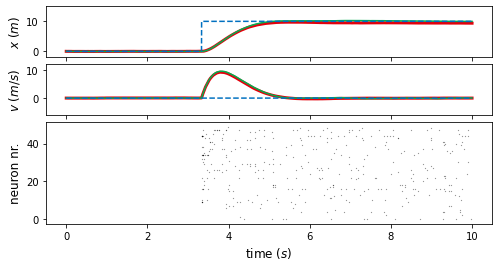

The total number of spikes in the simulation: 358
The average number of spikes per second: 35
The total number of spikes in control period: 358
The average number of spikes per second in control period: 23


In [312]:
plot_lam(1,show_legend=False)
print_sparsity_info(1)

<Figure size 432x288 with 0 Axes>

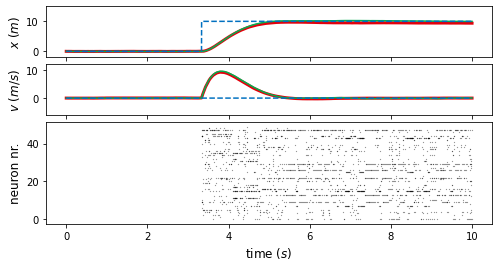

The total number of spikes in the simulation: 2381
The average number of spikes per second: 238
The total number of spikes in control period: 2381
The average number of spikes per second in control period: 158


In [313]:
plot_lam(2,show_legend=False)
print_sparsity_info(2)